# Latent Dirichlet Allocation
---
  
**LDA**  
- Probabilistic topic model. Assumes documents are a mixture of topics and that each word in the document is attributable to a topic  
- 

## Env Preparation

In [1]:
import os
import sys
# os.chdir('/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering')
os.chdir('/home/jovyan/work/')
print('Workdir: ', os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

Workdir:  /home/jovyan/work


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data Preparation

In [7]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l.split(' ')))
data.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,806
1,business,worldcom boss left books alone former worldc...,332
2,sport,tigers wary of farrell gamble leicester say ...,270
3,sport,yeading face newcastle in fa cup premiership s...,390
4,entertainment,ocean s twelve raids box office ocean s twelve...,287


In [10]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [11]:
#### Test on a sample of the data

In [12]:
sample = data.iloc[:2,:]
sample.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,806
1,business,worldcom boss left books alone former worldc...,332


In [13]:
sample['processed'] = sample['text'].apply(nlp).apply(spacy_cleaning)

In [14]:
print(sample['text'][0][:1000])

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [15]:
print(sample['processed'][0][:1000])

tv future hand viewer system plasma high definition tv digital video recorder move living room way people watch tv different year time accord expert panel gather annual consumer electronic discuss new technology impact favourite pastime lead trend programme content deliver viewer home network cable satellite telecom company broadband service provider room portable device talk technology ce digital personal video recorder dvr pvr set box system allow people record store play pause forward wind tv programme want technology allow personalised tv build high definition tv set big business lack high definition programming people wind advert forget abide network channel schedule put entertainment network cable satellite company worried mean term advertising revenue brand identity viewer loyalty channel lead technology moment concern raise grow uptake service happen today month year time futurologist tell like issue lose advertising revenue pressing issue moment commercial broadcaster brand lo

In [13]:
import time
start = time.time()
data['processed'] = data['text'].apply(nlp).apply(spacy_cleaning)
finish = time.time()
print('Done! It took me ', (finish-start))
data.to_csv(JP('data','bbc-text-processed.csv'))

Done! It took me  126.66121530532837


,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


In [4]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


In [18]:
doc_list = [d for d in data.text]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 933960. Unique words: 43772


In [19]:
doc_list = [d for d in data.processed]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 339642. Unique words: 15191


## Moving to a Catalog Format

In [12]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

catalog = Catalog()
catalog.documents = documents
_ = catalog.collect_corpus(attr='processed_text', form=list)


## Gensin

In [53]:
NUM_TOPICS = 5

In [54]:
data['processed_token'] = data['processed'].apply(lambda t: t.split())
data['processed_token']

0       [tv, future, hand, viewer, system, plasma, hig...
1       [left, book, ebber, accuse, oversee, 11bn, fra...
2       [wary, farrell, gamble, rush, make, bid, decid...
3       [yeade, face, premiership, face, trip, leader,...
4       [raid, ocean, crime, go, number, office, chart...
                              ...                        
2220    [car, pull, retail, figure, retail, sale, fall...
2221    [unveil, ex, chatshow, host, attack, policy, i...
2222    [concert, band, announce, plan, perform, scott...
2223    [political, squabble, snowball, s, commonplace...
2224    [delight, souness, feel, danger, go, early, go...
Name: processed_token, Length: 2225, dtype: object

In [55]:
from gensim import corpora, models, similarities 

# Create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(data['processed_token']) 
dictionary.filter_extremes(no_below=0.1, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in data['processed_token']]

In [56]:
ldaModel = models.LdaModel(
    corpus, 
    num_topics=NUM_TOPICS,
    id2word=dictionary, 
    update_every=5, 
    chunksize=1000, 
    passes=100)

In [57]:
ldaModel.show_topics()

[(0,
  '0.011*"government" + 0.008*"people" + 0.008*"election" + 0.007*"party" + 0.006*"plan" + 0.006*"tell" + 0.005*"labour" + 0.005*"new" + 0.005*"year" + 0.005*"law"'),
 (1,
  '0.014*"year" + 0.011*"company" + 0.010*"firm" + 0.008*"market" + 0.007*"rise" + 0.006*"sale" + 0.006*"price" + 0.006*"share" + 0.006*"growth" + 0.005*"month"'),
 (2,
  '0.023*"film" + 0.014*"award" + 0.013*"year" + 0.011*"win" + 0.009*"star" + 0.008*"include" + 0.008*"s" + 0.006*"actor" + 0.006*"take" + 0.005*"play"'),
 (3,
  '0.013*"people" + 0.010*"music" + 0.009*"game" + 0.008*"technology" + 0.008*"mobile" + 0.008*"phone" + 0.006*"new" + 0.006*"service" + 0.006*"use" + 0.006*"year"'),
 (4,
  '0.014*"win" + 0.012*"game" + 0.011*"play" + 0.011*"s" + 0.009*"time" + 0.008*"player" + 0.008*"year" + 0.006*"come" + 0.006*"go" + 0.006*"team"')]

## Topics and Words

In [58]:
ldaModel.show_topics(formatted=False, num_words=5)

[(0,
  [('government', 0.010733707),
   ('people', 0.008039685),
   ('election', 0.007824426),
   ('party', 0.006717689),
   ('plan', 0.006210278)]),
 (1,
  [('year', 0.014111888),
   ('company', 0.010571093),
   ('firm', 0.010044343),
   ('market', 0.008182151),
   ('rise', 0.00732972)]),
 (2,
  [('film', 0.022632226),
   ('award', 0.014064458),
   ('year', 0.013364364),
   ('win', 0.010727215),
   ('star', 0.008649058)]),
 (3,
  [('people', 0.013279508),
   ('music', 0.009949652),
   ('game', 0.009053779),
   ('technology', 0.008466713),
   ('mobile', 0.008392519)]),
 (4,
  [('win', 0.01382148),
   ('game', 0.0121776555),
   ('play', 0.011422328),
   ('s', 0.010814313),
   ('time', 0.008895256)])]

In [59]:
lda = ldaModel.show_topics(formatted=False, num_words=5)[0]
topic, (word,score) = lda

ValueError: too many values to unpack (expected 2)

In [ ]:
topic, word, score

In [52]:
results = defaultdict(lambda: defaultdict())
lda_result = lda.show_topics(formatted=False, num_words=5)
for (topic, (word,score)) in lda:
    results[topic][word] = results

AttributeError: 'tuple' object has no attribute 'show_topics'

## Visualization 

#### Helper Functions for Plotting

In [146]:
data = pd.melt(medoids.rename_axis('medoid').reset_index(), 
               id_vars=['medoid'], var_name='word', value_name='score')
data.head()


,medoid,word,score
0,Medoid_0,able,0.000
1,Medoid_1,able,0.000
2,Medoid_2,able,0.069
3,Medoid_3,able,0.099
4,Medoid_4,able,0.000


In [147]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)


---

---

# Plotting the WordClouds


### Alternative 1 - Use centroid as Cluster Information

3 2
(3, 2)


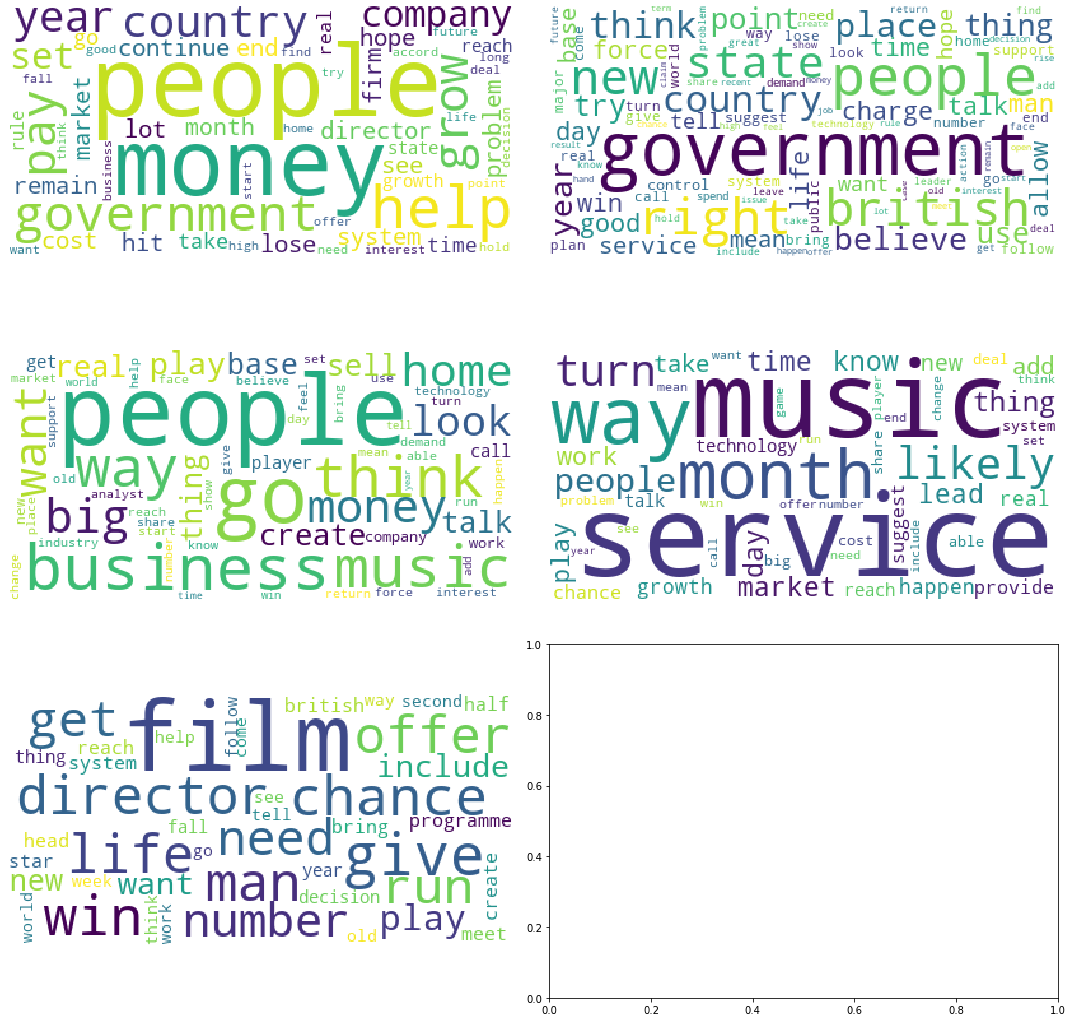

In [168]:
plot_centroids_as_wordclouds(tfidf,clusters,n_cols=2)

### Alternative 2.1 - Use information from all documents

In [52]:
subsample = sort_scores(RESULTS.dict['filtered_docs'], 'norm_tf_idf')
subsample.head()

,word,idf,max_tf_idf,avg_tf_idf,norm_tf_idf,centroid_score
69,game,0.635,1.000,1.000,1.000,1.000
80,win,0.383,0.834,0.860,0.807,0.860
19,play,0.488,0.768,0.760,0.751,0.760
143,player,0.710,0.907,0.609,0.687,0.609
84,match,0.985,0.971,0.490,0.614,0.490


3 2
(3, 2)


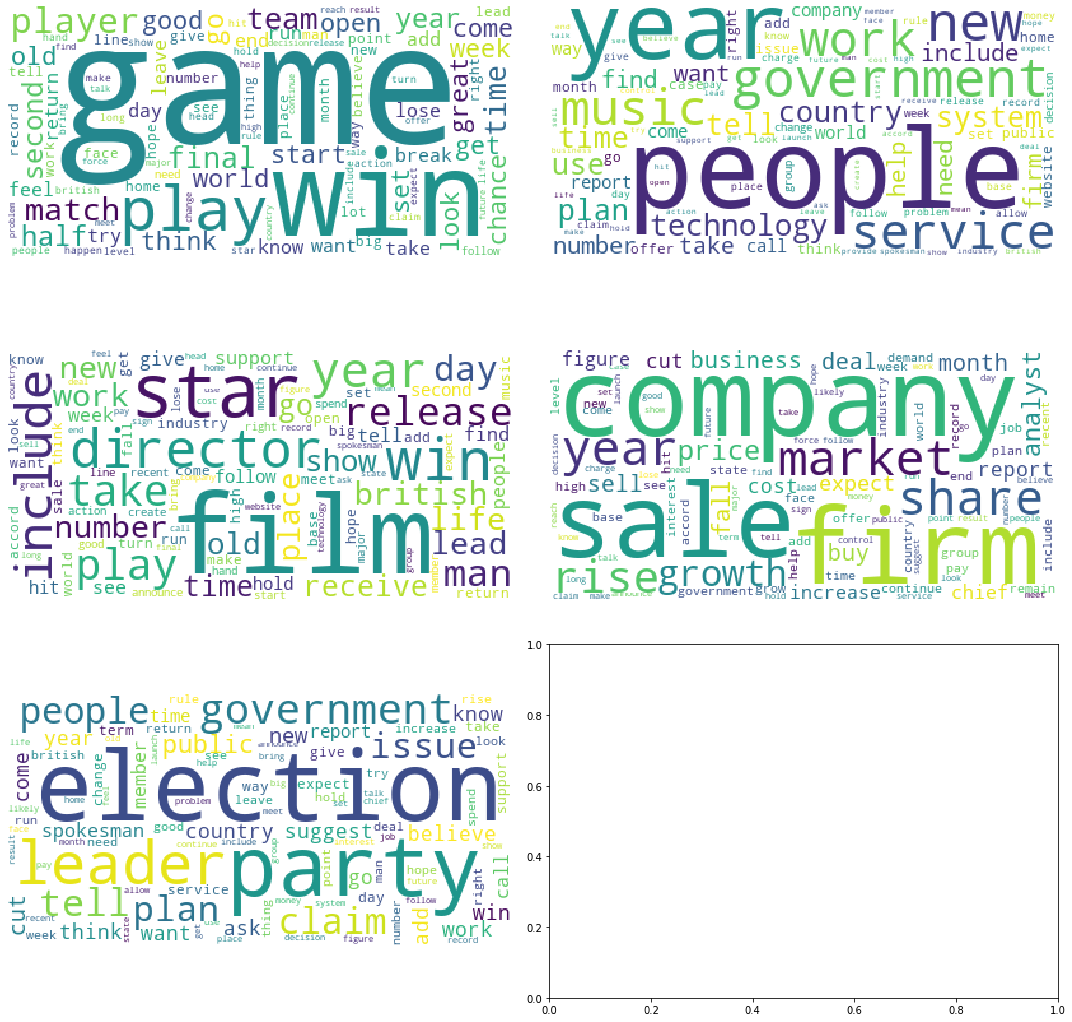

In [54]:
plot_centroids_as_wordclouds(tfidf_cluster_0, clusters,n_cols=2)

### Alternative 2.2 - Use information of the documents of that cluster